In [12]:
#Import Statements
import numpy as np
import pandas as pd
import skimage
import time
import sklearn.metrics
from skimage import data,io
from skimage.io import imread_collection
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt



## Data Exploration

In [13]:
#Importing the dataset
withmaskImages = io.ImageCollection('with_mask/*.jpg')
withoutmaskImages = io.ImageCollection('without_mask/*.jpg')

#Count number of pictures with mask and without mask 
print("Number of images with mask:", len(withmaskImages),"\nNumber of images without mask:", len(withoutmaskImages))



Number of images with mask: 3725 
Number of images without mask: 3828


I start by counting the number of images in each folder. The data initially starts off seperated into two folders, so they must be imported as two different arrays. The number of images with masks and without masks are counted, and we can see that there are a little more samples without a mask. 

In [14]:
for i in range(0,10):
    print(withmaskImages[i].shape)

(350, 525, 3)
(251, 201, 3)
(92, 66, 3)
(128, 102, 3)
(147, 99, 3)
(214, 141, 3)
(169, 138, 3)
(138, 98, 3)
(637, 422, 3)
(218, 135, 3)


In [15]:
for i in range(0,10):
    print(withoutmaskImages[i].shape)

(100, 100, 3)
(138, 148, 3)
(135, 136, 3)
(121, 153, 3)
(145, 144, 3)
(146, 151, 3)
(134, 128, 3)
(148, 135, 3)
(125, 149, 3)
(135, 154, 3)


Here I am printing the dimenions of the first few images in each array for each set of images. I want to do this to see the number of features of each sample, where multiplying the dimensions gets the total number of features per image. From printing these, we can see that these images will have different numbers of features due to the different dimensions there are. Because of this, in preprocessing we will have to make sure these images have the same number of features to use in processing the dataset.

## Pre-processing

In [16]:



#function for load_func parameter that converts images to grayscale and resizes them 
def processImage(filename, label):

    img = io.imread(filename, as_gray = True)
    img = skimage.transform.resize(img,(100,100))

    #Make an array in order to add the label to the image as another column
    img = np.array(img).flatten()
    img = np.append(img, label)
    return img

#reload images but as each image in imagecollection gets loaded, process the image, mask = 1, no mask = 0
withmaskImages = io.ImageCollection('with_mask/*.jpg', load_func = processImage, label = 1)
withoutmaskImages = io.ImageCollection('without_mask/*.jpg', load_func = processImage, label = 0)




Using the ImageCollection function from skimage, I create arrays of the images after processing them. I can pass through a function that will read the image and then transform it. First I resize the image to 100x10 because most of the images in the dataset are that size, and having every image be the same size means that I will have the same number of features for every sample. Then, the image is converted from rgb to grayscale to reduce the dimensionality of the image, there is one less channel making the data easier to process. Then, the label for the class is assigned to the image as well. A picture where a person is wearing a mask is a 1, and a picture where a person is not wearing a mask is a 0.

In [17]:
#concatenate_images turns image collection into matrix where one array represents one image with its corresponding label
withmaskArr = io.concatenate_images(withmaskImages)
withoutmaskArr = io.concatenate_images(withoutmaskImages)

#cut out some values from withoutmaskArr to keep same number of samples per class
withoutmaskArr = withoutmaskArr[0:3725]


concatenate_images turns the ImageCollection into a matrix where one array represents one image with its corresponding label. Then, to maintain a uniform distribution, some samples are cut from the without masks samples. 

In [18]:
#convert to dataframes to concatenate the two arrays 
withmaskArr = pd.DataFrame(withmaskArr)
withoutmaskArr = pd.DataFrame(withoutmaskArr)

arrays = [withmaskArr,withoutmaskArr]
df = pd.concat(arrays,ignore_index = True)

#shuffle data using sample method in pandas,reset_index(drop=True) will create new indexs, frac=1 means all data will be used
df = df.sample(frac=1).reset_index(drop=True)
#last col of df are the labels for the dataset
dfLabels = df.loc[:,df.shape[1]-1]


I use the concat function in pandas after converting the arrays to pandas dataframes to have the entire dataset in one array, so i can use this dataset for future data processing and modeling. Since all of the masks and no mask pictures are grouped together, I need to shuffle the entire dataset so this is not the case, and i do this with the shuffle method in pandas.

Since we attached the labels to the dataset earlier, we set the last column of our new dataset to be equal to a new variable representing the labels of the dataset. The purpose of this is to have a seperate labels variable to use in training and fitting our machine learning models.

In [19]:
#Standardizing the dataset(reason in markdown-need for pca, mean/vec,etc,look at documentation)

#need to drop label, it not used in normalization
df = df.drop(columns = df.shape[1]-1)

#print(np.mean(df))

#standardscaler normalizes dataset to have 0 mean and unit variance
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df))

#print(np.mean(df))

I use the StandardScaler function in sklearn to standardize the dataset. The dataset needs to be normalized in order to use PCA on this dataset. This is so that all variables have the same standard deviation during the PCA calculation, so it will properly reduce the dimensionality of the dataset without additional bias from differing standard deviations. The StandardScaler function subtracts the mean of the attribute from the current sample, and then divides by the standard deviation for that attribut. This is done on every sample in the dataset.

## Feature Extraction

In [20]:

#PCA on data to reduce the number of dimensions

#choose percent to reduce num of features to specific percentage of data(.96)- , svd_solver = full to make sure all data is processed
pca = PCA(0.96, svd_solver = 'full').fit(df)

#Apply dimensionality reduction
df = pca.transform(df)
print(df.shape)

(7450, 380)


PCA is done here to reduce the dimensionality of the images to make the data easier to work with. Starting out, the data has 10,000 features, which would greatly impact the performance of our models, so reducing this number will help make the calculations easier without losing much data when reducing dimensions. In this code I use the pca function from sklearn to keep a certain percentage of the data, which represents the number of principal components to keep from PCA. The covariance matrix of the dataset is calculated and then the eigenvalues and eigenvectors are calculated to find the given number principal components that help capture as much of the data as possible, with the most variance. This is found by sorting the eigenvectors to find the k principal components.

## Dataset Processing

In [21]:
#First Method: Suport Vector Classifier

df = pd.DataFrame(df)
dfLabels = pd.DataFrame(dfLabels)

#K-Folds
KFolds = KFold(5)
KFolds.get_n_splits(df)

C = [100, 50, 10, 1, .5]
tol = [50, 10, 1, .1, .01]

i = 0
for training,testing in KFolds.split(df):
    startTime = time.time()
    X_train_kfold, X_test_kfold = df.iloc[training], df.iloc[testing]
    y_train_kfold, y_test_kfold = dfLabels.iloc[training],dfLabels.iloc[testing]

    #Cross Validation for C parameter. want to have constant tol to properly tune C
    SVCmodel = SVC(C = C[i], kernel = 'rbf', tol = 50, decision_function_shape = 'ovo',max_iter=380)
    SVCmodel.fit(X_train_kfold,y_train_kfold)

    SVCpredictions = SVCmodel.predict(X_test_kfold)
    SVCaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,SVCpredictions)
    SVCmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,SVCpredictions)

    print("C =",C[i],": Accuracy Score =",SVCaccuracy, "Mean Square Error =", SVCmeanSquareError)
    
    i += 1




C = 100 : Accuracy Score = 0.5026845637583892 Mean Square Error = 0.49731543624161073
C = 50 : Accuracy Score = 0.4912751677852349 Mean Square Error = 0.508724832214765
C = 10 : Accuracy Score = 0.5 Mean Square Error = 0.5
C = 1 : Accuracy Score = 0.4959731543624161 Mean Square Error = 0.5040268456375839
C = 0.5 : Accuracy Score = 0.5100671140939598 Mean Square Error = 0.4899328859060403


The first classification method I am using for this dataset is a Support Vector Classifier. I am using the SVC function in sklearn. The goal of a SVC is to find the equation of a hyperplane, and to plot samples with the hyperplane and try to maximize the distance(the margin) of the hyperplane from all samples in the dataset. This function will use a hard margin classifier, where samples are not allowed to be within or on the margins. The function for the hyperplane needs the normal vector w, and a bias term b. Since this is a binary classification, I am using a one vs one classifier. I use a radial kernel here because a linear hyperplane would be more innacurate due to the amount of features, a linear model would not be able to properly fit the data. 

The C parameter is the slack budget which helps determine the regularization parameter that is multiplied by the hard margin distance. The sum of the hard margin distances will be smaller than the sum of the sums of the hard margins of each sample. 

I use k-fold cross validation with the KFold functions from sklearn. The purpose of doing k-fold cross validation here is to tune our parameters over multiple iterations so see which paramater value gives the lowest error. Since there is no seperate test data, the data is split into 5 folds. In each iteration, one fold is used as testing data while the rest of the folds are used as training data. This repeats until every fold has been used as testing data. 

The reason a Support Vector Classifier is being used in this dataset because it is a binary classification technique. Since each sample is a grayscale image, it has just one value for its singular channel, meaning it is easier to calculate distances to hyperplanes. The hyperplanes calculated with the radial kernel trick do not lose much accuracy when used in larger dimensional data as well.


In [22]:
tol = [50, 10, 1, .1, .01]
i = 0


for training,testing in KFolds.split(df):
    X_train_kfold, X_test_kfold = df.iloc[training], df.iloc[testing]#dont fully get these lines
    y_train_kfold, y_test_kfold = dfLabels.iloc[training],dfLabels.iloc[testing]

    #Cross Validation for tolerance parameter(look up other parameters)
    SVCmodel = SVC(C = 100, kernel = 'rbf', tol = tol[i], decision_function_shape = 'ovo',max_iter=380)
    SVCmodel.fit(X_train_kfold,y_train_kfold)

    SVCpredictions = SVCmodel.predict(X_test_kfold)
    SVCaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,SVCpredictions)
    SVCmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,SVCpredictions)

    print("Tolerance =",tol[i],": Accuracy Score =",SVCaccuracy, "Mean Square Error =", SVCmeanSquareError)
    
    i += 1

Tolerance = 50 : Accuracy Score = 0.5026845637583892 Mean Square Error = 0.49731543624161073
Tolerance = 10 : Accuracy Score = 0.4912751677852349 Mean Square Error = 0.508724832214765
Tolerance = 1 : Accuracy Score = 0.7583892617449665 Mean Square Error = 0.24161073825503357
Tolerance = 0.1 : Accuracy Score = 0.7221476510067114 Mean Square Error = 0.2778523489932886
Tolerance = 0.01 : Accuracy Score = 0.7053691275167785 Mean Square Error = 0.29463087248322145


In the previous cell, I was doing k fold cross validation to tune for C. In this cell, I am following the same process to tune the tol parameter. This is a parameter in sklean machine learning functions that tells the function to stop finding a min or max once the model is within the threshold of the tolerance. In this case, the model would stop searching for the min of its primal formulation once the margin is close enough to the tolerance threshold.  

In [23]:
#Best parameters: C = 1, tolerance = .1

sumSVCError = 0
sumSVCAccuracy = 0
svmTime = 0

for training,testing in KFolds.split(df):
    startTime = time.time()
    X_train_kfold, X_test_kfold = df.iloc[training], df.iloc[testing]#dont fully get these lines
    y_train_kfold, y_test_kfold = dfLabels.iloc[training],dfLabels.iloc[testing]

    SVCmodel = SVC(C = 1, kernel = 'rbf', tol = .1,decision_function_shape = 'ovo',max_iter=380)
    SVCmodel.fit(X_train_kfold,y_train_kfold)

    SVCpredictions = SVCmodel.predict(X_test_kfold)
    SVCaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,SVCpredictions)
    SVCmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,SVCpredictions)
    sumSVCError += SVCmeanSquareError
    sumSVCAccuracy += SVCaccuracy
    svmTime += time.time() - startTime


    print("Accuracy Score =",SVCaccuracy, "Mean Square Error =", SVCmeanSquareError)

print("\nAverage Accuracy Score:",sumSVCAccuracy/5, "Average Error:",sumSVCError/5)

Accuracy Score = 0.6771812080536913 Mean Square Error = 0.32281879194630875
Accuracy Score = 0.7013422818791947 Mean Square Error = 0.2986577181208054
Accuracy Score = 0.6590604026845638 Mean Square Error = 0.3409395973154362
Accuracy Score = 0.6577181208053692 Mean Square Error = 0.3422818791946309
Accuracy Score = 0.6778523489932886 Mean Square Error = 0.3221476510067114

Average Accuracy Score: 0.6746308724832215 Average Error: 0.32536912751677854


Once the best parameters have been found, I run the SVC function one more time with k fold cross validation to average the accuracy and error accross each fold to determine its performance. The mean squared error is the sum of the observed value minus the predicted value squared for every sample, divided by the number of data samples. This is a percentage of how many misclassifications were made in the dataset.

In [24]:
#Second method-KNN

k = [3,4,5,6,7]

i = 0

for training,testing in KFolds.split(df):
    X_train_kfold, X_test_kfold = df.iloc[training], df.iloc[testing]
    y_train_kfold, y_test_kfold = dfLabels.iloc[training],dfLabels.iloc[testing]

    #Cross Validation for k(look up other parameters), brute=brute force search, weights based on distance,p=2 euclidean distance,
    KNNmodel = KNeighborsClassifier(n_neighbors=k[i], algorithm = 'brute', weights = 'distance',p=2 ,n_jobs=-1)
    KNNmodel.fit(X_train_kfold,y_train_kfold)

    KNNpredictions = KNNmodel.predict(X_test_kfold)
    KNNaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,KNNpredictions)
    KNNmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,KNNpredictions)
   

    print("K =",k[i],": Accuracy Score =",KNNaccuracy, "Mean Square Error =", KNNmeanSquareError)
    
    i += 1



K = 3 : Accuracy Score = 0.7751677852348994 Mean Square Error = 0.22483221476510068
K = 4 : Accuracy Score = 0.8053691275167785 Mean Square Error = 0.19463087248322147
K = 5 : Accuracy Score = 0.7986577181208053 Mean Square Error = 0.20134228187919462
K = 6 : Accuracy Score = 0.8060402684563759 Mean Square Error = 0.19395973154362417
K = 7 : Accuracy Score = 0.8093959731543624 Mean Square Error = 0.1906040268456376


The second method I chose is K Nearest Neighbors(KNN). I chose KNN for this dataset due to the simple nature of this method for classification. Since it has good performance and since each data sample has been reduced to only one array from the grayscale image and PCA, it is easy to calculate distances between multiple samples, making this method run much faster than other methods, especially for this dataset which has not that many features after preprocessing.

KNN works by using a given distance calculation metric to calculate distances between every point relative to each other. Then, for each sample, KNN looks at the k smallest distances from that sample, and uses majority vote on the labels of those k smallest distances to determine the label of the current sample. 

The KNeighborsClassifier in sklearn is used to implement KNN. The number of neighbors,k, is the parameter that is being tuned here. The algorithm parameter is set to brute, which will just calculate distances for each sample from every single other sample. Settings weights to distance tells the function to use the distances as the metric for determining the K-nearest neighbors. p = 2 is the parameter that determines the distance metric, which in this case is euclidean distance. The n_jobs parameter simply tells the function to search for neighbors in parallel, increasing the overall speed of the function.


In [25]:
#Best K value is K=7

sumKNNError = 0
sumKNNAccuracy = 0
knnTime = 0

for training,testing in KFolds.split(df):
    startTime = time.time()
    X_train_kfold, X_test_kfold = df.iloc[training], df.iloc[testing]
    y_train_kfold, y_test_kfold = dfLabels.iloc[training],dfLabels.iloc[testing]

    KNNmodel = KNeighborsClassifier(n_neighbors=7, algorithm = 'brute', weights = 'distance',p=2 ,n_jobs=-1)
    KNNmodel.fit(X_train_kfold,y_train_kfold)

    KNNpredictions = KNNmodel.predict(X_test_kfold)
    KNNaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,KNNpredictions)
    KNNmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,KNNpredictions)
    sumKNNError += KNNmeanSquareError
    sumKNNAccuracy += KNNaccuracy
    knnTime += time.time() - startTime

    print("Accuracy Score =",KNNaccuracy, "Mean Square Error =", KNNmeanSquareError)

print("\nAverage Accuracy Score:",sumKNNAccuracy/5, "Average Error:",sumKNNError/5)


Accuracy Score = 0.789261744966443 Mean Square Error = 0.21073825503355706
Accuracy Score = 0.8080536912751678 Mean Square Error = 0.1919463087248322
Accuracy Score = 0.7986577181208053 Mean Square Error = 0.20134228187919462
Accuracy Score = 0.8 Mean Square Error = 0.2
Accuracy Score = 0.8093959731543624 Mean Square Error = 0.1906040268456376

Average Accuracy Score: 0.8010738255033558 Average Error: 0.1989261744966443


Once the k value has been tuned for, that value is used again in k fold cross validation to obtain an average accuracy and error over multiple validation folds.



In [26]:
#Third Method: lda

sumLDAError = 0
sumLDAAccuracy = 0
ldaTime = 0

for training,testing in KFolds.split(df):
    startTime = time.time()
    X_train_kfold, X_test_kfold = df.iloc[training], df.iloc[testing]
    y_train_kfold, y_test_kfold = dfLabels.iloc[training],dfLabels.iloc[testing]

    LDAmodel = LinearDiscriminantAnalysis()
    LDAmodel.fit(X_train_kfold,y_train_kfold)

    LDApredictions = LDAmodel.predict(X_test_kfold)
    LDAaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,LDApredictions)
    LDAmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,LDApredictions)
    sumLDAError += LDAmeanSquareError
    sumLDAAccuracy += LDAaccuracy
    ldaTime += time.time() - startTime

    print("Accuracy Score =",LDAaccuracy, "Mean Square Error =", LDAmeanSquareError)

print("\nAverage Accuracy Score:",sumLDAAccuracy/5, "Average Error:",sumLDAError/5)


Accuracy Score = 0.6557046979865772 Mean Square Error = 0.34429530201342284
Accuracy Score = 0.6718120805369128 Mean Square Error = 0.32818791946308723
Accuracy Score = 0.62751677852349 Mean Square Error = 0.3724832214765101
Accuracy Score = 0.663758389261745 Mean Square Error = 0.33624161073825504
Accuracy Score = 0.663758389261745 Mean Square Error = 0.33624161073825504

Average Accuracy Score: 0.656510067114094 Average Error: 0.34348993288590607


The third method I use for this dataset is Linear Discriminant Analysis(LDA). I choose to use this dataset because it uses the mean and variance of the dataset assuming that the data is a Gaussian distribution. Since I had to standardize the data in order to use PCA, the data is following this distribution, and the means and variances can be easily calculated, which the LDA function in sklearn does. The goal of LDA is to maximize a delta function for each class, using each class's mean and variance. The maximum delta value from each class will determine the prediction that the LDA model will make for that particular sample. The LinearDiscriminatAnalysis function in sklearn does not require any parameters to be tuned, so k fold cross validation doesnt need to be used to tune parameters but instead to get an average error and accuracy score to use in omparative analysis.

## Comparative Analysis

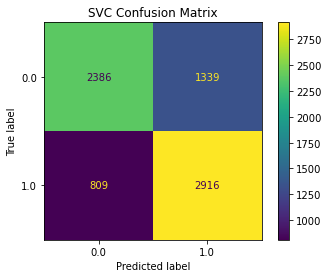

In [27]:
#Confusion Matrices

svcMatrix = sklearn.metrics.plot_confusion_matrix(SVCmodel,df,dfLabels)
plt.title("SVC Confusion Matrix")
plt.show()

Positives(class 0->without mask),Negatives(class 1->with mask)

SVC True Positives: 2386

SVC False Positives: 1339

SVC False Negatives: 809

SVC True Negatives: 2916


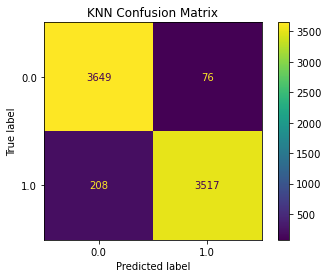

In [28]:
knnMatrix = sklearn.metrics.plot_confusion_matrix(KNNmodel,df,dfLabels)
plt.title("KNN Confusion Matrix")
plt.show()

KNN True Positives: 3649

KNN False Positives: 76

KNN False Negatives: 184

KNN True Negatives: 3541

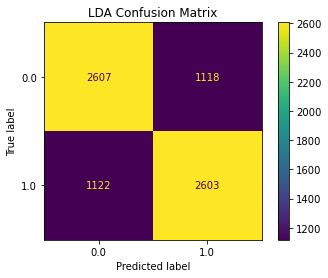

In [29]:
ldaMatrix = sklearn.metrics.plot_confusion_matrix(LDAmodel,df,dfLabels)
plt.title("LDA Confusion Matrix")
plt.show()

LDA True Positives: 2607

LDA False Positives: 1118

LDA False Negatives: 1122

LDA True Negatives: 2603

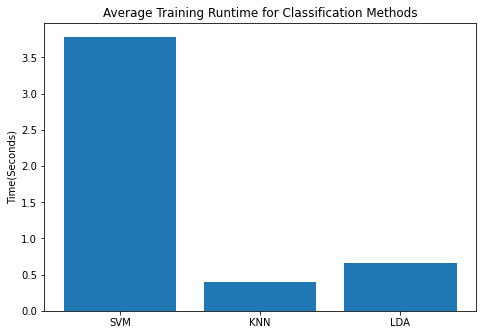

In [30]:
#Plot of average training runtime for each method, each time is run 5 times(for 5 k folds)

plot = plt.figure()
xlabels=['SVM','KNN','LDA']
values = [svmTime/5,knnTime/5,ldaTime/5]
fig = plot.add_axes([0,0,1,1])
fig.bar(xlabels,values)
plt.title('Average Training Runtime for Classification Methods')
plt.ylabel('Time(Seconds)')
plt.show()

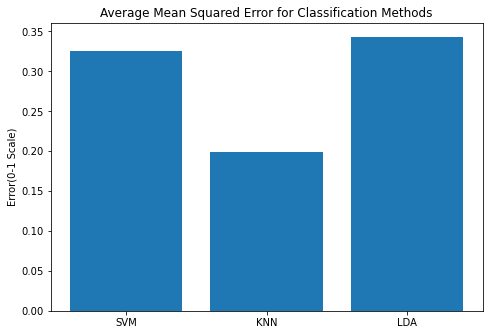

In [31]:
#Plot of average error for each method, 5 errors averaged across each k fold

plot = plt.figure()
xlabels=['SVM','KNN','LDA']
values = [sumSVCError/5,sumKNNError/5,sumLDAError/5]
fig = plot.add_axes([0,0,1,1])
fig.bar(xlabels,values)
plt.title('Average Mean Squared Error for Classification Methods')
plt.ylabel('Error(0-1 Scale)')
plt.show()

From the confusion matrices and the plots of runtime and average error, we can see that KNN is the best choice here, as it outperforms the other methods on all fronts. It has the lowest number of false positives and false negatives, it has the fastest runtime, and the lowest average mean squared error. Because of this, I would use KNN out of the three methods I picked to use in production.

## Ethical Issues

The main ethical issue with this dataset lies within the data itself. The pictures are pictures of real people. The pictures of the people were collected from online resources, but it may not be known if all of these people provided consent in having their picture taken or if they even knew about their picture being used in a machine learning model. If this model is applied in production, then it would need to be actively scanning peoples faces in order to determine whether they are wearing a mask or not. If sensors using a model like this were placed outside of a building to prevent entry if someone is not wearing a mask, then people may be uncomfortable with the idea that their face is being used to take an image and do something with that image through a computer.

## Bibliography

Bois, Justin. “Extracting Data from Images.” Caltech EDU, 18 Dec. 2019, bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/lessons/lesson_05/extracting_info_from_images.html. 

Kris. “Shuffle DataFrame Rows.” Stack Overflow, 1 Jan. 2016, stackoverflow.com/questions/29576430/shuffle-dataframe-rows. 

“Module: Io.collection.” Module: Io.collection - Skimage v0.7.0 Docs, 1 Jan. 2011, scikit-image.org/docs/0.7.0/api/skimage.io.collection.html. 

Pedregosa, Fabian, et al. “Scikit-Learn: Machine Learning in Python.” Journal of Machine Learning Research, 1 Jan. 2011, jmlr.csail.mit.edu/papers/v12/pedregosa11a.html. 